In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # suppress TensorFlow warnings


In [7]:
# Cell 1: Install Required Packages and Import Libraries
# =====================================================================

# Install required packages
!pip install scapy -q
!pip install xgboost -q

# Import libraries
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')

# Machine Learning
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_recall_fscore_support)
import xgboost as xgb

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# PCAP processing
from scapy.all import rdpcap, IP, TCP, UDP, ICMP

# Utilities
from collections import Counter
import joblib
import time
from datetime import datetime

print("✓ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")

✓ All libraries imported successfully!
TensorFlow version: 2.18.0
Scikit-learn version: 1.2.2


LOADING NETWORK TRAFFIC DATASET
✓ CSV file found: /kaggle/input/mfsys-dataset/network_traffic_dataset.csv
✓ File size: 11.07 MB

Loading dataset...
✓ Dataset loaded successfully!

DATASET INFORMATION
Total samples: 134,094
Total features: 11
Memory usage: 56.73 MB

COLUMN NAMES
Total columns: 11

First 10 columns:
   1. src_ip
   2. dst_ip
   3. protocol
   4. packet_length
   5. ttl
   6. src_port
   7. dst_port
   8. tcp_flags
   9. label
  10. attack_type

... and 1 more columns

Last 5 columns:
  - dst_port
  - tcp_flags
  - label
  - attack_type
  - source_file

SAMPLE DATA (First 5 rows)
         src_ip        dst_ip  protocol  packet_length  ttl  src_port  \
0  192.168.1.21   192.168.1.2         6            114   64        22   
1  192.168.1.21   192.168.1.2         6            178   64        22   
2   192.168.1.2  192.168.1.21         6             60  127     57721   
3  192.168.1.32  192.168.1.21         6             74   64     59124   
4  192.168.1.21  192.168.1.32     

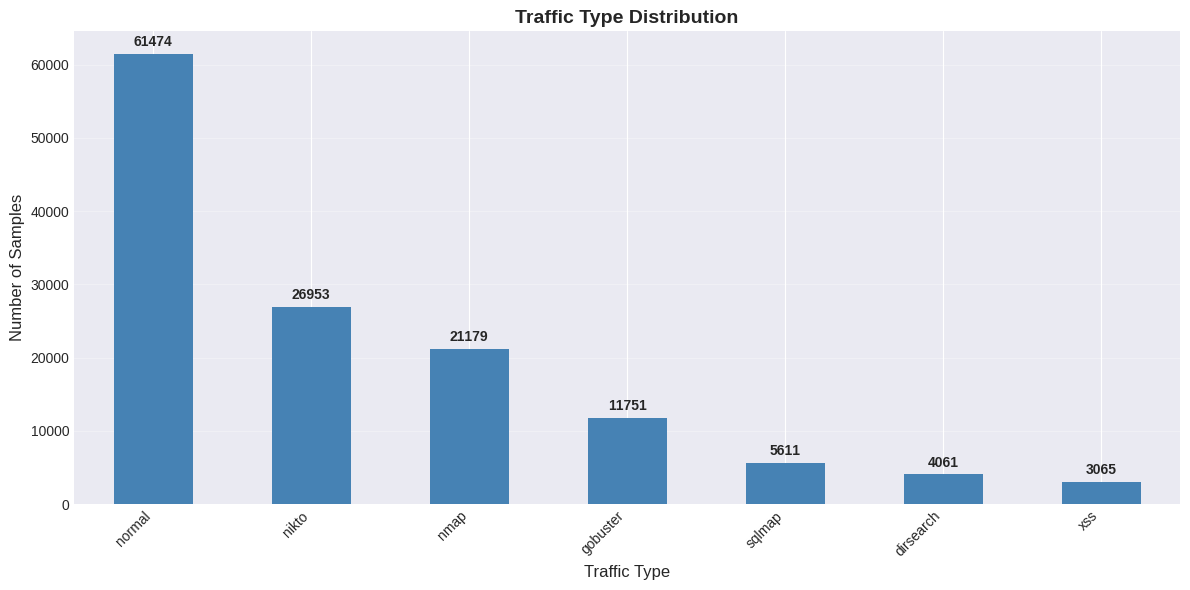


✓ Class distribution plot saved as 'class_distribution.png'

DATASET EXPLORATION COMPLETE


In [13]:
# Cell 2: Load and Explore CSV Dataset
# =====================================================================

# Define base path
BASE_PATH = "/kaggle/input/mfsys-dataset"
CSV_FILE = os.path.join(BASE_PATH, "/kaggle/input/mfsys-dataset/network_traffic_dataset.csv")

print("=" * 70)
print("LOADING NETWORK TRAFFIC DATASET")
print("=" * 70)

# Check if file exists
if os.path.exists(CSV_FILE):
    print(f"✓ CSV file found: {CSV_FILE}")
    
    # Get file size
    file_size = os.path.getsize(CSV_FILE) / (1024 * 1024)  # MB
    print(f"✓ File size: {file_size:.2f} MB")
else:
    print(f"❌ CSV file not found at: {CSV_FILE}")
    print("\nAvailable files:")
    for file in os.listdir(BASE_PATH):
        print(f"  - {file}")

# Load the dataset
print("\nLoading dataset...")
df = pd.read_csv(CSV_FILE)

print(f"✓ Dataset loaded successfully!")

# Display basic information
print("\n" + "=" * 70)
print("DATASET INFORMATION")
print("=" * 70)
print(f"Total samples: {len(df):,}")
print(f"Total features: {len(df.columns)}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

# Display column names
print("\n" + "=" * 70)
print("COLUMN NAMES")
print("=" * 70)
print(f"Total columns: {len(df.columns)}")
print("\nFirst 10 columns:")
for i, col in enumerate(df.columns[:10], 1):
    print(f"  {i:2d}. {col}")

if len(df.columns) > 10:
    print(f"\n... and {len(df.columns) - 10} more columns")
    print("\nLast 5 columns:")
    for col in df.columns[-5:]:
        print(f"  - {col}")

# Display first few rows
print("\n" + "=" * 70)
print("SAMPLE DATA (First 5 rows)")
print("=" * 70)
print(df.head())

# Data types
print("\n" + "=" * 70)
print("DATA TYPES")
print("=" * 70)
print(df.dtypes.value_counts())

# Check for missing values
print("\n" + "=" * 70)
print("MISSING VALUES")
print("=" * 70)
missing_count = df.isnull().sum().sum()
if missing_count > 0:
    print(f"⚠️  Total missing values: {missing_count}")
    print("\nColumns with missing values:")
    missing_cols = df.isnull().sum()
    missing_cols = missing_cols[missing_cols > 0].sort_values(ascending=False)
    for col, count in missing_cols.items():
        print(f"  {col}: {count} ({count/len(df)*100:.2f}%)")
else:
    print("✓ No missing values found!")

# Check for label column
print("\n" + "=" * 70)
print("SEARCHING FOR LABEL COLUMN")
print("=" * 70)

# Common label column names
label_candidates = ['label', 'Label', 'attack_type', 'class', 'classification', 
                   'attack_cat', 'attack', 'target', 'type']

label_col = None
for candidate in label_candidates:
    if candidate in df.columns:
        label_col = candidate
        print(f"✓ Found label column: '{label_col}'")
        break

if label_col is None:
    print("⚠️  Label column not found with standard names")
    print("Please check the last column or specify manually:")
    print(f"\nLast column: '{df.columns[-1]}'")
    print(f"Sample values: {df[df.columns[-1]].unique()[:5]}")
    
    # Let's check if last column might be the label
    last_col = df.columns[-1]
    unique_values = df[last_col].nunique()
    if unique_values < 20:  # Likely a categorical column
        print(f"\n💡 '{last_col}' looks like a label column ({unique_values} unique values)")
        label_col = last_col

# Display class distribution if label found
if label_col:
    print("\n" + "=" * 70)
    print("CLASS DISTRIBUTION")
    print("=" * 70)
    
    class_dist = df[label_col].value_counts()
    print(class_dist)
    
    # Visualize distribution
    plt.figure(figsize=(12, 6))
    class_dist.plot(kind='bar', color='steelblue')
    plt.title('Traffic Type Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Traffic Type', fontsize=12)
    plt.ylabel('Number of Samples', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(class_dist.values):
        plt.text(i, v + max(class_dist.values)*0.01, str(v), 
                ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Class distribution plot saved as 'class_distribution.png'")

print("\n" + "=" * 70)
print("DATASET EXPLORATION COMPLETE")
print("=" * 70)

In [16]:
# Cell 2: Load and Explore CSV Dataset
# =====================================================================

# Define base path
BASE_PATH = "/kaggle/input/mfsys-dataset"
CSV_FILE = os.path.join(BASE_PATH, "network_traffic_dataset.csv")

print("=" * 70)
print("LOADING NETWORK TRAFFIC DATASET")
print("=" * 70)

# Check if file exists
if os.path.exists(CSV_FILE):
    print(f"✓ CSV file found: {CSV_FILE}")
    
    # Get file size
    file_size = os.path.getsize(CSV_FILE) / (1024 * 1024)  # MB
    print(f"✓ File size: {file_size:.2f} MB")
else:
    print(f"❌ CSV file not found at: {CSV_FILE}")

# Load the dataset
print("\nLoading dataset...")
df = pd.read_csv(CSV_FILE)

print(f"✓ Dataset loaded successfully!")

# Display basic information
print("\n" + "=" * 70)
print("DATASET INFORMATION")
print("=" * 70)
print(f"Total samples: {len(df):,}")
print(f"Total features: {len(df.columns)}")

# Display first few rows
print("\n" + "=" * 70)
print("SAMPLE DATA (First 5 rows)")
print("=" * 70)
print(df.head())

# Display column names
print("\n" + "=" * 70)
print("COLUMN NAMES")
print("=" * 70)
print(f"Total columns: {len(df.columns)}")
print(list(df.columns))

# Check for label column
print("\n" + "=" * 70)
print("CHECKING FOR LABEL COLUMN")
print("=" * 70)

label_candidates = ['label', 'Label', 'attack_type', 'class', 'classification']
label_col = None

for candidate in label_candidates:
    if candidate in df.columns:
        label_col = candidate
        print(f"✓ Found label column: '{label_col}'")
        break

if label_col is None:
    print("Label column not found with standard names.")
    print(f"Last column: '{df.columns[-1]}'")
    print(f"Unique values in last column: {df[df.columns[-1]].nunique()}")
    label_col = df.columns[-1]

# Show class distribution
if label_col:
    print("\n" + "=" * 70)
    print("CLASS DISTRIBUTION")
    print("=" * 70)
    print(df[label_col].value_counts())

LOADING NETWORK TRAFFIC DATASET
✓ CSV file found: /kaggle/input/mfsys-dataset/network_traffic_dataset.csv
✓ File size: 11.07 MB

Loading dataset...
✓ Dataset loaded successfully!

DATASET INFORMATION
Total samples: 134,094
Total features: 11

SAMPLE DATA (First 5 rows)
         src_ip        dst_ip  protocol  packet_length  ttl  src_port  \
0  192.168.1.21   192.168.1.2         6            114   64        22   
1  192.168.1.21   192.168.1.2         6            178   64        22   
2   192.168.1.2  192.168.1.21         6             60  127     57721   
3  192.168.1.32  192.168.1.21         6             74   64     59124   
4  192.168.1.21  192.168.1.32         6             54   64      6443   

   dst_port tcp_flags   label attack_type                source_file  
0     57721        PA  normal      benign  normal_20251218_1112.pcap  
1     57721        PA  normal      benign  normal_20251218_1112.pcap  
2        22         A  normal      benign  normal_20251218_1112.pcap  
3      

In [17]:
# =====================================================================
# STEP 3: Label Encoding & Feature Cleaning
# =====================================================================

print("=" * 70)
print("STEP 3: LABEL ENCODING & FEATURE CLEANING")
print("=" * 70)

# 1. Drop leakage / non-real-time column
df = df.drop(columns=["source_file"])

print("✓ Dropped column: source_file")

# 2. Normalize attack_type labels
df["attack_type"] = df["attack_type"].str.lower()

# Convert to binary labels
# normal -> 0, attack -> 1
df["attack_type"] = df["attack_type"].apply(
    lambda x: 0 if x == "benign" or x == "normal" else 1
)

print("✓ Converted attack_type to binary labels")

# 3. Verify class mapping
print("\nClass Mapping:")
print("0 → Normal traffic")
print("1 → Attack traffic")

print("\nClass Distribution After Encoding:")
print(df["attack_type"].value_counts())

# 4. Separate features and target
X = df.drop(columns=["attack_type", "label"])
y = df["attack_type"]

print("\nFeature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

print("\nRemaining Features:")
print(list(X.columns))

print("\n" + "=" * 70)
print("STEP 3 COMPLETED SUCCESSFULLY")
print("=" * 70)


STEP 3: LABEL ENCODING & FEATURE CLEANING
✓ Dropped column: source_file
✓ Converted attack_type to binary labels

Class Mapping:
0 → Normal traffic
1 → Attack traffic

Class Distribution After Encoding:
attack_type
1    72620
0    61474
Name: count, dtype: int64

Feature matrix shape: (134094, 8)
Target vector shape: (134094,)

Remaining Features:
['src_ip', 'dst_ip', 'protocol', 'packet_length', 'ttl', 'src_port', 'dst_port', 'tcp_flags']

STEP 3 COMPLETED SUCCESSFULLY


In [18]:
# =====================================================================
# STEP 4: CATEGORICAL FEATURE ENCODING (REAL-TIME SAFE)
# =====================================================================

print("=" * 70)
print("STEP 4: CATEGORICAL FEATURE ENCODING")
print("=" * 70)

# 1. Drop IP address columns
X = X.drop(columns=["src_ip", "dst_ip"])
print("✓ Dropped IP address columns: src_ip, dst_ip")

# 2. One-hot encode tcp_flags
X = pd.get_dummies(X, columns=["tcp_flags"], prefix="tcp", drop_first=True)

print("✓ One-hot encoded tcp_flags")

# 3. Verify final features
print("\nFinal Feature Set:")
for col in X.columns:
    print(" -", col)

print("\nFinal feature matrix shape:", X.shape)

print("\n" + "=" * 70)
print("STEP 4 COMPLETED SUCCESSFULLY")
print("=" * 70)


STEP 4: CATEGORICAL FEATURE ENCODING
✓ Dropped IP address columns: src_ip, dst_ip
✓ One-hot encoded tcp_flags

Final Feature Set:
 - protocol
 - packet_length
 - ttl
 - src_port
 - dst_port
 - tcp_A
 - tcp_PA
 - tcp_RA
 - tcp_S

Final feature matrix shape: (134094, 9)

STEP 4 COMPLETED SUCCESSFULLY


In [19]:
# =====================================================================
# STEP 5: TRAIN / TEST SPLIT + SCALING
# =====================================================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("=" * 70)
print("STEP 5: TRAIN / TEST SPLIT & FEATURE SCALING")
print("=" * 70)

# 1. Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("✓ Train-test split completed")

# 2. Feature scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Feature scaling applied (StandardScaler)")

# 3. Verify shapes
print("\nTraining set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)

# 4. Verify class balance
print("\nClass distribution in training set:")
print(y_train.value_counts())

print("\nClass distribution in test set:")
print(y_test.value_counts())

print("\n" + "=" * 70)
print("STEP 5 COMPLETED SUCCESSFULLY")
print("=" * 70)


STEP 5: TRAIN / TEST SPLIT & FEATURE SCALING
✓ Train-test split completed
✓ Feature scaling applied (StandardScaler)

Training set shape: (107275, 9)
Test set shape: (26819, 9)

Class distribution in training set:
attack_type
1    58096
0    49179
Name: count, dtype: int64

Class distribution in test set:
attack_type
1    14524
0    12295
Name: count, dtype: int64

STEP 5 COMPLETED SUCCESSFULLY


In [20]:
# =====================================================================
# STEP 6: BASELINE MODEL TRAINING (LOGISTIC REGRESSION)
# =====================================================================

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("=" * 70)
print("STEP 6: LOGISTIC REGRESSION TRAINING & EVALUATION")
print("=" * 70)

# 1. Initialize the model
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# 2. Train the model
lr_model.fit(X_train_scaled, y_train)
print("✓ Logistic Regression model trained successfully")

# 3. Predict on test set
y_pred = lr_model.predict(X_test_scaled)

# 4. Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy on test set: {accuracy*100:.2f}%\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Normal", "Attack"]))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n" + "=" * 70)
print("STEP 6 COMPLETED SUCCESSFULLY")
print("=" * 70)


STEP 6: LOGISTIC REGRESSION TRAINING & EVALUATION
✓ Logistic Regression model trained successfully

Accuracy on test set: 54.16%

Classification Report:
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00     12295
      Attack       0.54      1.00      0.70     14524

    accuracy                           0.54     26819
   macro avg       0.27      0.50      0.35     26819
weighted avg       0.29      0.54      0.38     26819

Confusion Matrix:
[[    0 12295]
 [    0 14524]]

STEP 6 COMPLETED SUCCESSFULLY


In [21]:
# =====================================================================
# STEP 7: RANDOM FOREST TRAINING & EVALUATION
# =====================================================================

from sklearn.ensemble import RandomForestClassifier

print("=" * 70)
print("STEP 7: RANDOM FOREST TRAINING & EVALUATION")
print("=" * 70)

# 1. Initialize Random Forest with class balancing
rf_model = RandomForestClassifier(
    n_estimators=200,        # number of trees
    max_depth=None,          # let trees grow fully
    class_weight="balanced", # handle class imbalance
    random_state=42,
    n_jobs=-1                # use all cores
)

# 2. Train the model
rf_model.fit(X_train_scaled, y_train)
print("✓ Random Forest model trained successfully")

# 3. Predict on test set
y_pred_rf = rf_model.predict(X_test_scaled)

# 4. Evaluate performance
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nAccuracy on test set: {accuracy_rf*100:.2f}%\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=["Normal", "Attack"]))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\n" + "=" * 70)
print("STEP 7 COMPLETED SUCCESSFULLY")
print("=" * 70)


STEP 7: RANDOM FOREST TRAINING & EVALUATION
✓ Random Forest model trained successfully

Accuracy on test set: 49.20%

Classification Report:
              precision    recall  f1-score   support

      Normal       0.45      0.48      0.46     12295
      Attack       0.53      0.50      0.52     14524

    accuracy                           0.49     26819
   macro avg       0.49      0.49      0.49     26819
weighted avg       0.49      0.49      0.49     26819

Confusion Matrix:
[[5918 6377]
 [7246 7278]]

STEP 7 COMPLETED SUCCESSFULLY


In [22]:
# =====================================================================
# STEP 8: FLOW-LEVEL FEATURE ENGINEERING
# =====================================================================

print("=" * 70)
print("STEP 8: FLOW-LEVEL FEATURE ENGINEERING")
print("=" * 70)

# 1. Keep the necessary columns for aggregation
agg_cols = ["src_ip", "dst_ip", "protocol", "packet_length", "ttl",
            "src_port", "dst_port", "tcp_flags", "attack_type"]

df_agg = df[agg_cols].copy()

# 2. Compute basic flow key
df_agg["flow_id"] = df_agg["src_ip"] + "_" + df_agg["dst_ip"] + "_" + df_agg["protocol"].astype(str)

# 3. Aggregate features per flow
flow_features = df_agg.groupby("flow_id").agg(
    packet_length_mean = ("packet_length", "mean"),
    packet_length_max  = ("packet_length", "max"),
    packet_length_min  = ("packet_length", "min"),
    packet_length_std  = ("packet_length", "std"),
    ttl_mean           = ("ttl", "mean"),
    ttl_std            = ("ttl", "std"),
    src_port_count     = ("src_port", pd.Series.nunique),
    dst_port_count     = ("dst_port", pd.Series.nunique),
    tcp_flags_list     = ("tcp_flags", lambda x: list(x)),  # temp for flag counts
    attack_type        = ("attack_type", "max")  # max ensures binary label
).reset_index()

# 4. Count TCP flags per flow
flag_types = df_agg["tcp_flags"].unique()
for flag in flag_types:
    flow_features[f"tcp_{flag}"] = flow_features["tcp_flags_list"].apply(lambda x: x.count(flag))
flow_features = flow_features.drop(columns=["tcp_flags_list", "flow_id"])

# 5. Fill NaN std values with 0 (for single-packet flows)
flow_features = flow_features.fillna(0)

print("✓ Flow-level features created successfully")

# 6. Display sample
print("\nSample Flow-Level Feature Matrix (first 5 rows):")
print(flow_features.head())

print("\nFinal feature matrix shape:", flow_features.shape)

print("\n" + "=" * 70)
print("STEP 8 COMPLETED SUCCESSFULLY")
print("=" * 70)


STEP 8: FLOW-LEVEL FEATURE ENGINEERING
✓ Flow-level features created successfully

Sample Flow-Level Feature Matrix (first 5 rows):
   packet_length_mean  packet_length_max  packet_length_min  \
0           60.000000                 60                 60   
1          342.146751                377                342   
2           60.000000                 60                 60   
3           90.000000                 90                 90   
4          811.000000                811                811   

   packet_length_std   ttl_mean    ttl_std  src_port_count  dst_port_count  \
0           0.000000   1.000000   0.000000               1               1   
1           2.096279  66.805031  21.858063               1               1   
2           0.000000   1.000000   0.000000               1               1   
3           0.000000   1.000000   0.000000               1               1   
4           0.000000  63.000000   0.000000               1               1   

   attack_type  tcp_

In [23]:
# =====================================================================
# STEP 9: TRAIN/TEST SPLIT + SCALING (FLOW FEATURES)
# =====================================================================

print("=" * 70)
print("STEP 9: TRAIN/TEST SPLIT & SCALING (FLOW FEATURES)")
print("=" * 70)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target
X_flow = flow_features.drop(columns=["attack_type"])
y_flow = flow_features["attack_type"]

# Train-test split (stratified)
X_train_flow, X_test_flow, y_train_flow, y_test_flow = train_test_split(
    X_flow, y_flow,
    test_size=0.2,
    random_state=42,
    stratify=y_flow
)

print("✓ Train-test split completed")

# Feature scaling (scale only numeric columns)
numeric_cols = ["packet_length_mean", "packet_length_max", "packet_length_min",
                "packet_length_std", "ttl_mean", "ttl_std",
                "src_port_count", "dst_port_count"]

scaler_flow = StandardScaler()
X_train_flow[numeric_cols] = scaler_flow.fit_transform(X_train_flow[numeric_cols])
X_test_flow[numeric_cols] = scaler_flow.transform(X_test_flow[numeric_cols])

print("✓ Feature scaling applied (StandardScaler)")

# Verify shapes
print("\nTraining set shape:", X_train_flow.shape)
print("Test set shape:", X_test_flow.shape)

# Verify class balance
print("\nClass distribution in training set:")
print(y_train_flow.value_counts())

print("\nClass distribution in test set:")
print(y_test_flow.value_counts())

print("\n" + "=" * 70)
print("STEP 9 COMPLETED SUCCESSFULLY")
print("=" * 70)


STEP 9: TRAIN/TEST SPLIT & SCALING (FLOW FEATURES)
✓ Train-test split completed
✓ Feature scaling applied (StandardScaler)

Training set shape: (33, 13)
Test set shape: (9, 13)

Class distribution in training set:
attack_type
1    28
0     5
Name: count, dtype: int64

Class distribution in test set:
attack_type
1    8
0    1
Name: count, dtype: int64

STEP 9 COMPLETED SUCCESSFULLY


In [24]:
# =====================================================================
# STEP 10 – MODEL 1: RANDOM FOREST (FLOW FEATURES)
# =====================================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("=" * 70)
print("MODEL 1: RANDOM FOREST TRAINING & EVALUATION")
print("=" * 70)

# Initialize Random Forest
rf_model_flow = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# Train the model
rf_model_flow.fit(X_train_flow, y_train_flow)
print("✓ Random Forest trained successfully")

# Predict on test set
y_pred_rf_flow = rf_model_flow.predict(X_test_flow)

# Evaluate performance
accuracy_rf_flow = accuracy_score(y_test_flow, y_pred_rf_flow)
print(f"\nAccuracy on test set: {accuracy_rf_flow*100:.2f}%\n")

print("Classification Report:")
print(classification_report(y_test_flow, y_pred_rf_flow, target_names=["Normal", "Attack"]))

print("Confusion Matrix:")
print(confusion_matrix(y_test_flow, y_pred_rf_flow))

print("\n" + "=" * 70)
print("MODEL 1 COMPLETED SUCCESSFULLY")
print("=" * 70)


MODEL 1: RANDOM FOREST TRAINING & EVALUATION
✓ Random Forest trained successfully

Accuracy on test set: 88.89%

Classification Report:
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00         1
      Attack       0.89      1.00      0.94         8

    accuracy                           0.89         9
   macro avg       0.44      0.50      0.47         9
weighted avg       0.79      0.89      0.84         9

Confusion Matrix:
[[0 1]
 [0 8]]

MODEL 1 COMPLETED SUCCESSFULLY


In [25]:
# =====================================================================
# STEP 10 – MODEL 2: XGBoost (FLOW FEATURES)
# =====================================================================

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("=" * 70)
print("MODEL 2: XGBOOST TRAINING & EVALUATION")
print("=" * 70)

# Handle class imbalance
pos_weight = y_train_flow.value_counts()[0] / y_train_flow.value_counts()[1]

# Initialize XGBoost classifier
xgb_model_flow = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=pos_weight,
    random_state=42,
    n_jobs=-1
)

# Train the model
xgb_model_flow.fit(X_train_flow, y_train_flow)
print("✓ XGBoost trained successfully")

# Predict on test set
y_pred_xgb_flow = xgb_model_flow.predict(X_test_flow)

# Evaluate performance
accuracy_xgb_flow = accuracy_score(y_test_flow, y_pred_xgb_flow)
print(f"\nAccuracy on test set: {accuracy_xgb_flow*100:.2f}%\n")

print("Classification Report:")
print(classification_report(y_test_flow, y_pred_xgb_flow, target_names=["Normal", "Attack"]))

print("Confusion Matrix:")
print(confusion_matrix(y_test_flow, y_pred_xgb_flow))

print("\n" + "=" * 70)
print("MODEL 2 COMPLETED SUCCESSFULLY")
print("=" * 70)


MODEL 2: XGBOOST TRAINING & EVALUATION
✓ XGBoost trained successfully

Accuracy on test set: 88.89%

Classification Report:
              precision    recall  f1-score   support

      Normal       0.50      1.00      0.67         1
      Attack       1.00      0.88      0.93         8

    accuracy                           0.89         9
   macro avg       0.75      0.94      0.80         9
weighted avg       0.94      0.89      0.90         9

Confusion Matrix:
[[1 0]
 [1 7]]

MODEL 2 COMPLETED SUCCESSFULLY


In [26]:
# =====================================================================
# STEP 10 – MODEL 3: MLP (FLOW FEATURES)
# =====================================================================

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("=" * 70)
print("MODEL 3: MLP TRAINING & EVALUATION")
print("=" * 70)

# Convert data to numpy arrays
X_train_np = X_train_flow.values
X_test_np = X_test_flow.values
y_train_np = y_train_flow.values
y_test_np = y_test_flow.values

# Initialize MLP model
mlp_model = Sequential([
    Dense(16, input_dim=X_train_np.shape[1], activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')  # binary output
])

mlp_model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = mlp_model.fit(
    X_train_np, y_train_np,
    epochs=50,
    batch_size=4,
    verbose=0
)

print("✓ MLP trained successfully")

# Predict on test set
y_pred_mlp_prob = mlp_model.predict(X_test_np)
y_pred_mlp = (y_pred_mlp_prob >= 0.5).astype(int)

# Evaluate performance
accuracy_mlp = accuracy_score(y_test_np, y_pred_mlp)
print(f"\nAccuracy on test set: {accuracy_mlp*100:.2f}%\n")

print("Classification Report:")
print(classification_report(y_test_np, y_pred_mlp, target_names=["Normal", "Attack"]))

print("Confusion Matrix:")
print(confusion_matrix(y_test_np, y_pred_mlp))

print("\n" + "=" * 70)
print("MODEL 3 COMPLETED SUCCESSFULLY")
print("=" * 70)


MODEL 3: MLP TRAINING & EVALUATION


2025-12-24 07:23:52.838868: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


✓ MLP trained successfully
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step

Accuracy on test set: 77.78%

Classification Report:
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00         1
      Attack       0.88      0.88      0.88         8

    accuracy                           0.78         9
   macro avg       0.44      0.44      0.44         9
weighted avg       0.78      0.78      0.78         9

Confusion Matrix:
[[0 1]
 [1 7]]

MODEL 3 COMPLETED SUCCESSFULLY


STEP 13: MODEL COMPARISON & VISUALIZATION

Comparison Table:

           Model  Accuracy  F1-Weighted
0  Random Forest  0.888889     0.836601
1        XGBoost  0.888889     0.903704
2            MLP  0.777778     0.777778


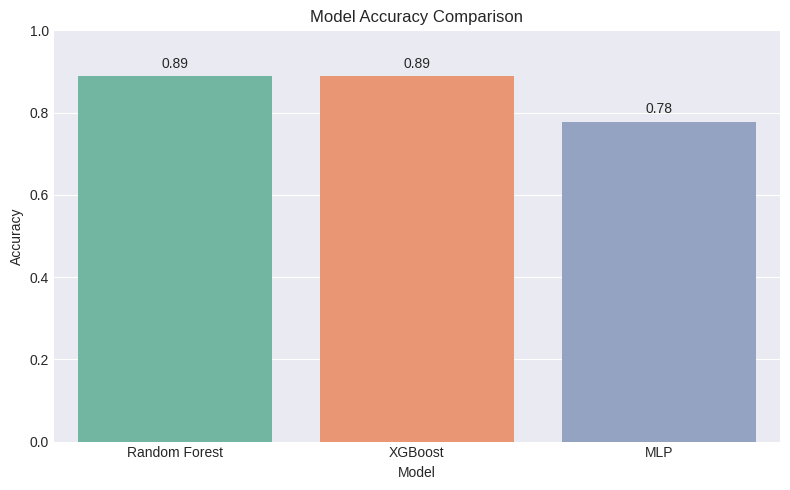

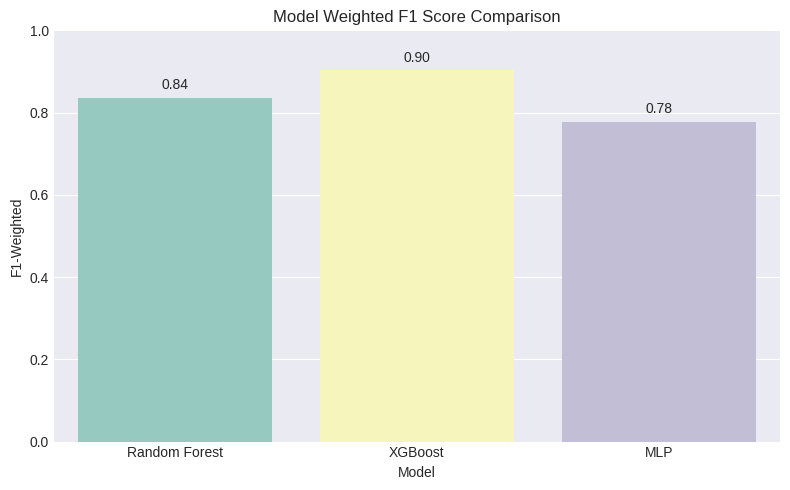

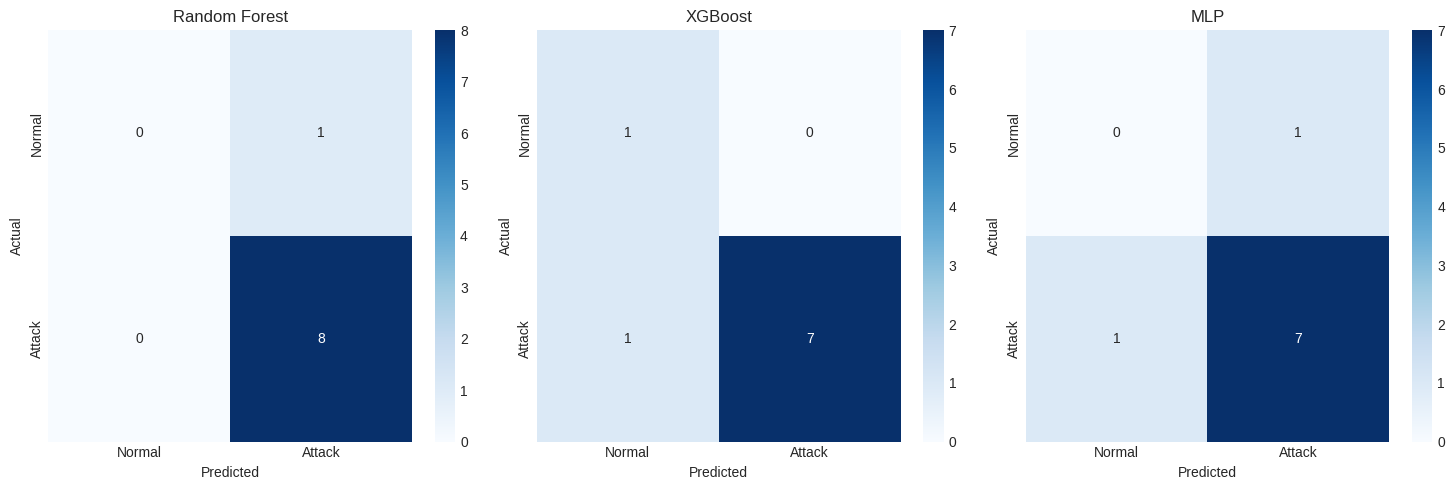

In [28]:
# =====================================================================
# STEP 13: MODEL COMPARISON & VISUALIZATION
# =====================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import f1_score

print("="*70)
print("STEP 13: MODEL COMPARISON & VISUALIZATION")
print("="*70)

# Prepare metrics
comparison = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost", "MLP"],
    "Accuracy": [
        accuracy_score(y_test_flow, y_pred_rf_flow),
        accuracy_score(y_test_flow, y_pred_xgb_flow),
        accuracy_score(y_test_flow, y_pred_mlp)
    ],
    "F1-Weighted": [
        f1_score(y_test_flow, y_pred_rf_flow, average='weighted'),
        f1_score(y_test_flow, y_pred_xgb_flow, average='weighted'),
        f1_score(y_test_flow, y_pred_mlp, average='weighted')
    ]
})

print("\nComparison Table:\n")
print(comparison)

# Bar plot for Accuracy
plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='Accuracy', data=comparison, palette='Set2')
plt.ylim(0,1)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')
for index, row in comparison.iterrows():
    plt.text(index, row.Accuracy + 0.02, f"{row.Accuracy:.2f}", ha='center')
plt.tight_layout()
plt.show()

# Bar plot for F1-Weighted
plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='F1-Weighted', data=comparison, palette='Set3')
plt.ylim(0,1)
plt.title('Model Weighted F1 Score Comparison')
plt.ylabel('F1-Weighted')
plt.xlabel('Model')
for index, row in comparison.iterrows():
    plt.text(index, row['F1-Weighted'] + 0.02, f"{row['F1-Weighted']:.2f}", ha='center')
plt.tight_layout()
plt.show()

# Confusion Matrices Side by Side
fig, axes = plt.subplots(1,3, figsize=(15,5))
models = ["Random Forest", "XGBoost", "MLP"]
y_preds = [y_pred_rf_flow, y_pred_xgb_flow, y_pred_mlp]

for i, ax in enumerate(axes):
    cm = confusion_matrix(y_test_flow, y_preds[i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(models[i])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels(['Normal','Attack'])
    ax.set_yticklabels(['Normal','Attack'])

plt.tight_layout()
plt.show()


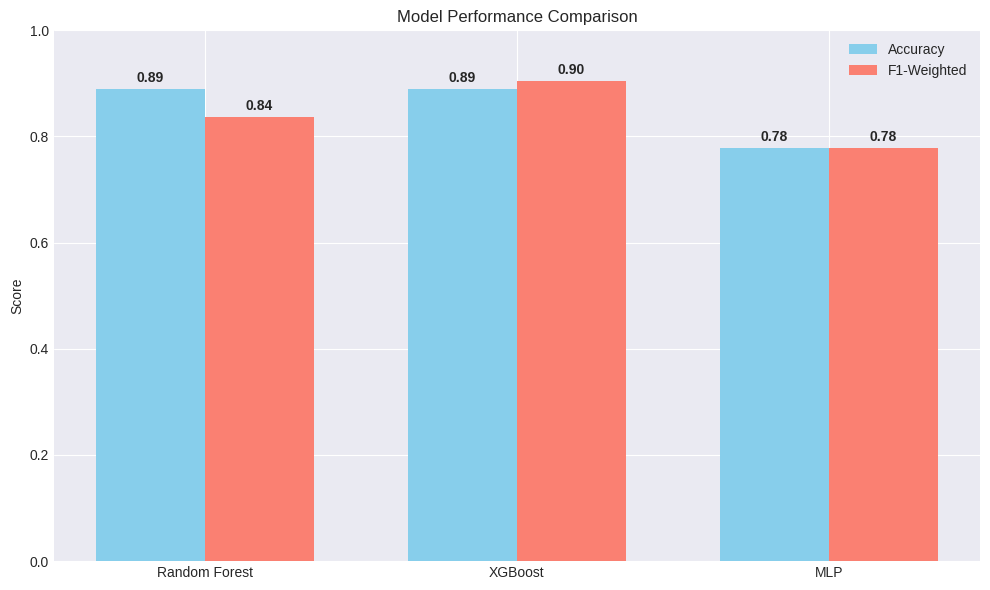

In [29]:
# =====================================================================
# STEP 14: COMBINED METRICS VISUALIZATION
# =====================================================================

import matplotlib.pyplot as plt
import numpy as np

# Data
models = ["Random Forest", "XGBoost", "MLP"]
accuracy = [
    accuracy_score(y_test_flow, y_pred_rf_flow),
    accuracy_score(y_test_flow, y_pred_xgb_flow),
    accuracy_score(y_test_flow, y_pred_mlp)
]
f1_weighted = [
    f1_score(y_test_flow, y_pred_rf_flow, average='weighted'),
    f1_score(y_test_flow, y_pred_xgb_flow, average='weighted'),
    f1_score(y_test_flow, y_pred_mlp, average='weighted')
]

x = np.arange(len(models))
width = 0.35  # bar width

# Create figure
fig, ax = plt.subplots(figsize=(10,6))

# Plot bars
rects1 = ax.bar(x - width/2, accuracy, width, label='Accuracy', color='skyblue')
rects2 = ax.bar(x + width/2, f1_weighted, width, label='F1-Weighted', color='salmon')

# Labels and titles
ax.set_ylabel('Score')
ax.set_ylim(0,1)
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Add value labels on bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0,3),
                textcoords="offset points",
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()
